# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 
Not all users receive the same offer, and that is the challenge to solve with this data set.
This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.
Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.


## Project Aim

The aim is to combine transactional, demographic and offer data to determine which demographic groups respond best to which type of offer. 
Heuristics should be developed to indicate which offer is best sent to a customer.


## Data Sets

The data is contained in three files:

* df_portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* df_profile.json - demographic data for each customer
* df_transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**df_portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**df_profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**df_transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Project structure

#### 1) Data Exploration
The first step is to examine the data.

#### 2) Cleaning
In order to be able to process the data further, it is cleaned in the next step.

#### 3) Data Visualization
Initial findings from the data are presented in graphs.

#### 4) Implementation
This part makes up the main part of the work. To calculate the heuristic, all offers must first be analyzed. It must be evaluated how much a customer spends when influenced by an offer and how much he spends when not influenced. In conclusion, a recommendation must be made.

# 1) Data Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math
import json
import re
%matplotlib inline

# read in the json files
df_portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
df_profile = pd.read_json('data/profile.json', orient='records', lines=True)
df_transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## df_portfolio

In [2]:
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
df_portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

There are 4 different types of BOGO, 4 types of discount and 2 types of informational advertising. 

In [4]:
df_portfolio['difficulty'].value_counts().sort_index()

0     2
5     2
7     1
10    4
20    1
Name: difficulty, dtype: int64

Most of the offers have a difficulty of 10, but there is also one with 20.

## df_profile

In [5]:
df_profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [6]:
df_profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [7]:
df_profile['gender'].isna().sum()

2175

There are about 8500 men and 6000 women in the dataset. 200 have selected 'other' and the remaining 2000 have not specified gender.

In [8]:
df_profile['age'].isna().sum()

0

In [9]:
df_profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64

There are said to be 2175 customers 118 years old. Since this age is unrealistic, these customers are excluded from further consideration.

In [10]:
df_age=df_profile['age']
df_age=df_age[df_age<118]
df_age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

The minimum age is 18 and the maximum age is 101. On average, customers are 54 years old. It seems that in the case of missing age 118 is deposited.

In [11]:
df_profile['income'].isna().sum()

2175

In [12]:
df_profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Salaries range from 30,000 to 120,000, with an average client earning 65,000.

In [13]:
df_profile[(df_profile['gender'].isna()) & (df_profile['age']==118) & (df_profile['income'].isna())].shape[0]

2175

It is interesting that the missing data always appear in bundles. Either a customer has specified gender, age and income, or none of them.

## df_transcript

In [14]:
df_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [15]:
df_transcript['person'].value_counts().count()

17000

There are records of 17,000 people. As many as there are in df_profile.

In [16]:
df_transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The dataset contains four different event types: Transaction means a sales volume generated by the customer. Each new quote that a customer receives is called 'offer received'. When a customer looks at the offer, an 'offer viewed' event is generated and when they complete it, an 'offer completed' event is generated. It is plausible that there are more 'offer received' than from 'offer viewed' and 'offer completed'.

In [17]:
first_time = df_transcript['time'].min()
first_time

0

In [18]:
last_time=df_transcript['time'].max()
last_time

714

The 'time' column records the time of the event in hours. The record starts at 0 and ends at 714.

In [19]:
df_transcript[df_transcript['event']=='offer received']['value'].value_counts()

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    7677
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    7668
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    7658
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    7646
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}    7632
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    7618
{'offer id': '3f207df678b143eea3cee63160fa8bed'}    7617
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    7597
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    7593
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    7571
Name: value, dtype: int64

In [20]:
df_transcript[df_transcript['event']=='offer viewed']['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    7337
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    7327
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    7298
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    7264
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    6716
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    6687
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    4171
{'offer id': '3f207df678b143eea3cee63160fa8bed'}    4144
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}    4118
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    2663
Name: value, dtype: int64

In [21]:
df_transcript[df_transcript['event']=='offer completed']['value'].value_counts()

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}     5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}     5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}     4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}     4296
{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}     4017
{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}    3688
{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'reward': 5}     3420
{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}    3331
Name: value, dtype: int64

The 'value' column contains the amount for a transaction. In case of an offer it contains the offer id. There are all 10 types, except for 'offer completed': there are only 8 different entries. This is true, because the two types with information advertisements can not be completed.

# 2) Cleaning

## df_portfolio

In [22]:
df_portfolio.sort_values(by=['offer_type', 'duration', 'difficulty'], inplace=True)
df_portfolio = df_portfolio.reset_index(drop=True)
df_portfolio.rename({'id':'offer type id', 'offer_type':'offer type'}, axis=1, inplace=True)
df_portfolio=df_portfolio.reindex(['offer type id','offer type', 'difficulty', 'reward', 'duration', 'channels'], axis=1)
df_portfolio

,offer type id,offer type,difficulty,reward,duration,channels
0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"[web, email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"[web, email, mobile, social]"
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"[web, email, mobile]"
3,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]"
4,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"[web, email, mobile, social]"
5,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"[web, email, mobile]"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"[web, email, mobile, social]"
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"[web, email]"
8,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"[email, mobile, social]"
9,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"[web, email, mobile]"


The rows are re-sorted depending on the offer type.

In [23]:
def simplify_id (ids, value_set=True):
    if value_set:
        s = set(ids)
    else:
        s =ids
    d = dict()
    i =0
    for s_id in s:
        d[s_id]=i
        i+=1
    return d

In [24]:
dict_offer_types=simplify_id(df_portfolio['offer type id'], value_set=False)
df_portfolio['offer type id']=df_portfolio['offer type id'].apply(lambda x: dict_offer_types[x])
df_portfolio

,offer type id,offer type,difficulty,reward,duration,channels
0,0,bogo,5,5,5,"[web, email, mobile, social]"
1,1,bogo,10,10,5,"[web, email, mobile, social]"
2,2,bogo,5,5,7,"[web, email, mobile]"
3,3,bogo,10,10,7,"[email, mobile, social]"
4,4,discount,7,3,7,"[web, email, mobile, social]"
5,5,discount,10,2,7,"[web, email, mobile]"
6,6,discount,10,2,10,"[web, email, mobile, social]"
7,7,discount,20,5,10,"[web, email]"
8,8,informational,0,0,3,"[email, mobile, social]"
9,9,informational,0,0,4,"[web, email, mobile]"


To increase readability, the IDs are reassigned numerically.

## df_profile

In [25]:
df_profile['became_member_on']=pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')
df_profile['age'].replace(118,0, inplace=True)
df_profile['income'].fillna(value=0, inplace=True)
df_profile['income']=df_profile['income']/1000
df_profile['income']=df_profile['income'].astype(int)
df_profile.rename({'id':'person id', 'income': 'income [k]', 'became_member_on':'member since'}, axis=1, inplace=True)
df_profile=df_profile.reindex(['person id', 'age', 'gender', 'income [k]', 'member since'], axis=1)
df_profile

,person id,age,gender,income [k],member since
0,68be06ca386d4c31939f3a4f0e3dd783,0,None,0,2017-02-12
1,0610b486422d4921ae7d2bf64640c50b,55,F,112,2017-07-15
2,38fe809add3b4fcf9315a9694bb96ff5,0,None,0,2018-07-12
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100,2017-05-09
4,a03223e636434f42ac4c3df47e8bac43,0,None,0,2017-08-04
...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,45,F,54,2018-06-04
16996,2cb4f97358b841b9a9773a7aa05a9d77,61,M,72,2018-07-13
16997,01d26f638c274aa0b965d24cefe3183f,49,M,73,2017-01-26
16998,9dc1421481194dcd9400aec7c9ae6366,83,F,50,2016-03-07


In [26]:
dict_person=simplify_id(df_profile['person id'])
n_person = len(dict_person)
df_profile['person id']=df_profile['person id'].apply(lambda x: dict_person[x])
df_profile

,person id,age,gender,income [k],member since
0,3801,0,None,0,2017-02-12
1,6242,55,F,112,2017-07-15
2,10230,0,None,0,2018-07-12
3,6721,75,F,100,2017-05-09
4,12912,0,None,0,2017-08-04
...,...,...,...,...,...
16995,643,45,F,54,2018-06-04
16996,5202,61,M,72,2018-07-13
16997,8021,49,M,73,2017-01-26
16998,10431,83,F,50,2016-03-07


Again, the person IDs have been reassigned numerically to increase readability.

## df_transcript

In [27]:
def extract_offer_id(s):
    '''
    used to get the offer id from a string.
    INPUT
    s - string

    OUTPUT
    the offer id if one was found, otherwise 'None'
    '''
    try:
        return re.search("\{'offer.id': '(.*?)'.*\}",str(s)).group(1)
    except:
        return None
    
def extract_amount(s):
    '''
    used to get the spended amount from a string.
    INPUT
    s - string

    OUTPUT
    the spended amount if one was found, otherwise 'None'
    '''
    try:
        return np.round(float(re.search("\{'amount': (.*?)\}",str(s)).group(1)),decimals=2)
    except:
        return None
    
def event_order (e):
    if e =='offer received':
        return 1
    elif e == 'offer viewed':
        return 2
    elif e == 'transaction':
        return 3
    elif  e== 'offer completed':
        return 4
    else:
        assert False

In [28]:
df_transcript['offer type id']=df_transcript['value'].transform(extract_offer_id)
df_transcript['amount']=df_transcript['value'].transform(extract_amount)
df_transcript.drop(columns='value', inplace=True)
df_transcript.rename({'person':'person id', 'time':'time [h]'}, axis=1, inplace=True)
df_transcript=df_transcript.reindex(['time [h]', 'person id', 'event', 'offer type id', 'amount'], axis=1)
df_transcript['person id']=df_transcript['person id'].apply(lambda x: dict_person[x])
df_transcript['offer type id']=df_transcript['offer type id'].apply(lambda x: dict_offer_types[x] if x is not None else -1)
df_transcript['order']=df_transcript['event'].apply(lambda x: event_order(x))
df_transcript.sort_values(by=['time [h]', 'order'])
df_transcript.drop(columns='order', inplace=True)
df_transcript

,time [h],person id,event,offer type id,amount
0,0,6721,offer received,2,NaN
1,0,12912,offer received,7,NaN
2,0,2695,offer received,5,NaN
3,0,16209,offer received,6,NaN
4,0,10310,offer received,1,NaN
...,...,...,...,...,...
306529,714,13182,transaction,-1,1.59
306530,714,11603,transaction,-1,9.53
306531,714,13256,transaction,-1,3.61
306532,714,12157,transaction,-1,3.53


In [29]:
df_transcript['amount'][~df_transcript['amount'].isnull()].sort_values().tail(10)

27692      947.43
280202     957.15
280015     961.21
21490      962.10
294112     966.24
302951     977.78
140346     989.34
42253     1001.85
301790    1015.73
284273    1062.28
Name: amount, dtype: float64

There are some orders that are very high. But they are not considered implausible, because it could be that one person invited a larger group.

In [30]:
#df_transcript.loc[(df_transcript['amount']>50),'amount']=50

This line of code can be executed to cap high transactions.

# 3) Data Visualization

In [31]:
import seaborn as sb
base_color = sb.color_palette()[0]

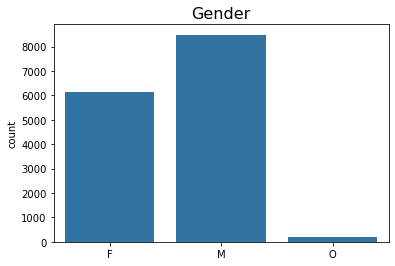

In [32]:
sb.countplot(x=df_profile['gender'], color=base_color)
plt.xlabel('')
plt.title('Gender', fontsize=16);

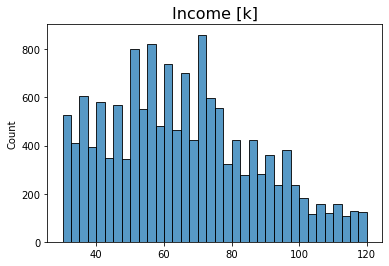

In [33]:
sb.histplot(x=df_profile['income [k]'][df_profile['income [k]']>0])
plt.xlabel('')
plt.title('Income [k]', fontsize=16);

We see a right-skewed normal distribution regarding income.

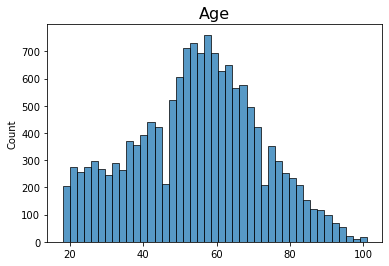

In [34]:
sb.histplot(x=df_profile['age'][df_profile['age']>0])
plt.xlabel('')
plt.title('Age', fontsize=16);

The age is normally distributed.

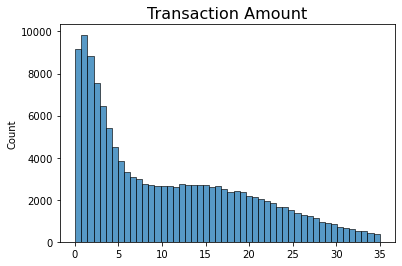

In [35]:
sb.histplot(x=df_transcript['amount'][df_transcript['amount']<35], bins=50)
plt.xlabel('')
plt.title('Transaction Amount', fontsize=16);

Most of the transactions were below 5.

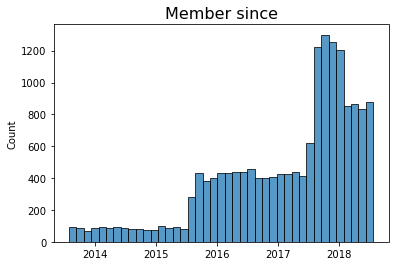

In [36]:
sb.histplot(x=df_profile['member since'])
plt.xlabel('')
plt.title('Member since', fontsize=16);

Among the newly created accounts in the app, you can see two jumps since which the membership numbers increased more.

# 4) Implementation

In this part, the heuristics will be developed to generate recommendations for offers for each customer.

In [37]:
df_trans_ext=df_transcript.merge(right=df_portfolio, on='offer type id', how='left')
df_trans_ext.drop(columns='channels', inplace=True)
df_trans_ext['active offers']=-1
df_trans_ext

,time [h],person id,event,offer type id,amount,offer type,difficulty,reward,duration,active offers
0,0,6721,offer received,2,NaN,bogo,5.0,5.0,7.0,-1
1,0,12912,offer received,7,NaN,discount,20.0,5.0,10.0,-1
2,0,2695,offer received,5,NaN,discount,10.0,2.0,7.0,-1
3,0,16209,offer received,6,NaN,discount,10.0,2.0,10.0,-1
4,0,10310,offer received,1,NaN,bogo,10.0,10.0,5.0,-1
...,...,...,...,...,...,...,...,...,...,...
306529,714,13182,transaction,-1,1.59,NaN,NaN,NaN,NaN,-1
306530,714,11603,transaction,-1,9.53,NaN,NaN,NaN,NaN,-1
306531,714,13256,transaction,-1,3.61,NaN,NaN,NaN,NaN,-1
306532,714,12157,transaction,-1,3.53,NaN,NaN,NaN,NaN,-1


**df_trans_ext** gives further details for each offer. In addition, the column **active offers** should show the number of active offers that influence the customer (but it has to be calculated at first). The offers can influence the customer only if the customer has viewed an offer!  

In the next step an offer will be implemented via a class:

In [38]:
class Offer:
    counter=0
    d_running = list()
    d_closed = dict()
    
    def __init__(self, offer_type_id, start_time, person_id):
        '''
        contructor to create a new Offer object 
        
        INPUT
        offer_type_id - the ID of the type of the offer
        start_time - The time of receiving the offer in hours after experiment start.
        person_id - The ID of the person
        '''
        self.person_id = person_id
        self.offer_type_id=offer_type_id
        self.offer_type=get_offer_type(offer_type_id)
        self.start_time=start_time
        self.duration=get_duration(offer_type_id)
        self.end_time_plan=start_time+self.duration*24
        self.state='open'
        self.id = Offer.counter
        self.end_time = -1
        self.money_spend = 0
        Offer.counter+=1
        
        self.offer_viewed=-1
        if self.offer_type == 'informational':
            self.offer_completed_expired=-1
        else:
            self.offer_completed_expired=self.end_time_plan
        
    def update_end_time(self, start_time):
        '''
        is needed to recalculate the end time of the offer. Only relevant for information offers, because they 
        affect the customer only from the moment of viewing and the end time must be recalculated, 
        because in this case the end time does not depend on the moment of receiving.
        
        INPUT
        start_time - The time of receiving the offer in hours after experiment start.
        '''
        self.start_time=start_time
        self.duration=get_duration(self.offer_type_id)
        self.end_time_plan=start_time+self.duration*24
        self.offer_completed_expired=self.end_time_plan
        
    def to_dict(self):
        '''
        returns a dictionary with all attributes of the object
        '''
        return {
            'offer id': self.id,
            'person id': self.person_id,
            'offer type id': self.offer_type_id,
            'offer type': self.offer_type,
            'state': self.state,
            'offer received': self.start_time,
            'offer viewed': self.offer_viewed,
            'offer completed/expired': self.offer_completed_expired,
            'money spent': self.money_spend
        }

The following helper functions are needed to calculate the offers:

In [39]:
def get_duration (offer_type_id):
    '''
    Outputs the duration for how long the offer is valid
    
    INPUT
    offer_type_id - the ID of the type of the offer
    
    OUTPUT
    duration for how long the offer is valid
    '''
    return df_portfolio.loc[df_portfolio['offer type id']==offer_type_id,'duration'].values[0]
    
def get_offer_type (offer_type_id):
    '''
    Outputs the offer type
    
    INPUT
    offer_type_id - the ID of the type of the offer
    
    OUTPUT
    the offer type
    '''
    return df_portfolio.loc[df_portfolio['offer type id']==offer_type_id,'offer type'].values[0]

def close_offer(offer_or_type_id, end_time=-1, n_occurrence=1, type_object=False):
    '''
    Terminates a valid offer because it is fulfilled or expired.
    
    INPUT
    offer_or_type_id - the ID of the type of the offer, or an offer object
    end_time - the time in hours after experiment start when the offer ends.
    n_occurrence - if several offers with the same type ID are valid, this will select the n-th offer.
    type_object - indicates whether offer_or_type_id contains an object or an id. 
                  If true, then offer_or_type_id contains in object.
    
    '''
    if not type_object:
        offer = Offer.d_running[get_index(offer_or_type_id, n_occurrence)]
    else:
        offer = offer_or_type_id
    if end_time != -1:
        offer.end_time = end_time
    else:
        offer.end_time = offer.end_time_plan
    Offer.d_closed[offer.id] = offer
    Offer.d_running.remove(offer)
    
def get_index(offer_type_id, n_occurrence=1):
    '''
    Returns the index of the object with the corresponding ID in Offer.d_running
    
    INPUT
    offer_or_type_id - the ID of the type of the offer, or an offer object
    n_occurrence - if several offers with the same type ID are valid, this will select the n-th offer.
    '''
    i=0
    occ=1
    for offer in Offer.d_running:
        if offer.offer_type_id==offer_type_id:
            if occ>=n_occurrence:
                return i
            else:
                occ+=1
        i+=1

def get_offer(offer_type_id, occurrence=1):
    '''
    Returns the object with the corresponding ID in Offer.d_running
    
    INPUT
    offer_or_type_id - the ID of the type of the offer, or an offer object
    n_occurrence - if several offers with the same type ID are valid, this will select the n-th offer.
    '''    
    occ=1
    for offer in Offer.d_running:
        if offer.offer_type_id==offer_type_id:
            if occ>=occurrence:
                return offer
            else:
                occ+=1
                    
def df_transcript_person (person_id, offers=False):
    '''
    Returns a DataFrame with the transactions from the respective customer
    
    INPUT
    person_id - the ID of the respective customer
    offers - if True, the events 'offer received', 'offer viewed' and 'offer completed' are also output in the DataFrame.
    
    OUTPUT
    DataFrame with the transcript of the respective customer
    '''
    df = df_trans_ext[df_trans_ext['person id']==person_id]
    if offers:
        return df
    else:
        return df[df['event']=='transaction']

In the following function **calculate_offers** the offers are calculated as objects and then stored in a Data Frame. For this purpose, the transcript is considered individually for each customer. For each offer there must be an 'offer received' transcript. Then a new offer is created as an object. Since there is no entry when an offer expires, this date must be calculated manually. Each offer object stores how much money was spent by the customer in the active period after the offer was viewed. One difficulty is assigning offer events to the correct offer, since there is no offer ID in the transcript for this purpose. However, there is the offer type ID which stands for one of the 10 different types, such as BOGO or discount. In some cases a customer gets several offers with the same type ID. An offer viewed event can then not be uniquely assigned to an offer. In these ambiguous cases, the offer that is started first is assumed.
Information advertising has no difficulty and no expiration date. It is assumed, depending on the type, that the advertisement will have an impact on the customer for three or four days after viewing it. Unlike the other types of offers, the duration until the expiration date counts only from the viewing time and not from the delivery time. 

Every offer is in a certain state at any given time. There are 12 possible states:

| State | Description | relevant for
| --- | --- | --- |
| open | The offer has been sent but not yet viewed. It has not expired yet.  | B,D,I |
| active | The offer has been considered and has not expired yet. <br>The customer is thus influenced by the offer. | B,D,I |
| successful | The offer was viewed and fulfilled before the expiration time. | B,D |
| expired | The offer was considered but not fulfilled before the expiration time. | B,D |
| ended | The offer has been viewed and the influence period of 3 or 4 days has passed. | I |
| expired without viewed | The offer has not been viewed and the offer period has passed without the task being fulfilled. | B,D |
| ended without viewed | The offer was not viewed until the end of the data set. | I |
| successful without viewed | The offer was not viewed, but fulfilled before the expiration time. | B,D |
| viewed after expiration | The offer was not fulfilled and viewed only after the expiration time. | B,D |
| viewed after success | The offer was fulfilled before the expiration time, but was not viewed before it was fulfilled. | B,D |
| still open after end of experiment | The end of the offer is after hour 714 and the offer has not yet been viewed.  | B,D,I |
| still active after end of experiment | The end of the offer is after hour 714 and the offer has already been viewed.  | B,D,I |

B= BOGO, D = Discount, I = Informational  

In [40]:
def calculate_offers():
    '''
    Calculates all offers and returns them in a DataFrame.
    
    OUTPUT
    DataFrame with all calculated offers    
    '''
    # Delete all offers from the previous run if the function is called more than once
    Offer.d_closed.clear()
    
    # For each person, the transaction flow is gone through individually.
    for p in range (n_person):
        
        # dfx contains the transaction flow for person p
        dfx=df_transcript_person(p, offers=True)
        # add one row at the end of the experiment. This is necessary to force a final loop run further down.
        # (The loop does not run every hour, but only when an event or transaction takes place.)
        dfx=pd.concat([dfx,pd.DataFrame({'time [h]':714, 'person id':p, 'event': 'final', 'offer type id':-1, 
                                         'active offers':-1}, index=[-1])])
        
        # Open or active offers are managed in Offer.d_running. 
        # When a new person is considered, there must be no old open offers.
        assert not Offer.d_running
        for i in dfx.index:
            
            # "occ" means the n-th occurrence of the concrete offer type ID in Offer.d_running
            # The "break" at the end of the loop will only make it run more times when the "continue" command is called, 
            # due to multiple active offers with the same offer type id.
            for occ in range(1,10):
                time = dfx.loc[i, 'time [h]']
                event = dfx.loc[i,'event']
                offer_type_id = dfx.loc[i,'offer type id']
                
                # STEP 1: PROCESS ENTRY
                
                # When the loop has reached the last line, only STEP 2 should check 
                # whether offers have already expired.
                if event=='final':
                    pass
                
                # If the current entry is a transaction, the spent amount will be added to all active offers. 
                # (Active offers have already been viewed and have not yet expired.)
                elif event=='transaction':
                    active_offers=0
                    for o in Offer.d_running:
                        if o.state == 'active' and time <= o.end_time_plan:
                            o.money_spend+=dfx.loc[i,'amount']
                            active_offers+=1
                    df_trans_ext.loc[i,'active offers']=active_offers
                    
                # If it is a new offer, a new object will be created.    
                elif event=='offer received':
                    Offer.d_running.append(Offer(offer_type_id, time, p))
                else:
                    
                    # In all other cases, the entry must refer to an offer object that has already been created.
                    offer = get_offer(offer_type_id,occ)
                    assert offer != None, (i, time)
                    
                    # If it is an "offer viewed" event, some case distinctions are made. 
                    # If the found object has already been viewed, the loop run is aborted with the "continue" command, 
                    # because the wrong object is selected.
                    if event=='offer viewed':
                        if offer.state == 'active':
                            continue
                        if offer.offer_type == 'informational' and (offer.state == 'open' or 
                                                                    offer.state == 'ended without viewed'):
                                offer.update_end_time(time)                        
                        offer.offer_viewed = time
                        if offer.state == 'open' or offer.state == 'ended without viewed':
                            offer.state='active'
                        elif offer.state == 'successful without viewed':
                            offer.state = 'viewed after success'
                            close_offer(offer_type_id, time,occ)
                        elif offer.state == 'expired without viewed':
                            offer.state = 'viewed after expiration'
                            close_offer(offer_type_id, time,occ)
                        else:
                            assert False, offer.state
                            
                    # If it is an "offer completed" event, some case distinctions are made. 
                    # If the found object has already been completed, the loop run is aborted with the "continue" command,
                    # because the wrong object is selected.        
                    elif event=='offer completed':
                        if offer.state == 'successful without viewed' or offer.state == 'expired without viewed':
                            continue
                        offer.offer_completed_expired = time
                        if offer.state == 'open':
                            offer.state='successful without viewed'
                        elif offer.state == 'active':
                            offer.state='successful'
                            close_offer(offer_type_id, time,occ)
                        else:
                            assert False, offer.state
                
                ## STEP 2: CLOSE EXPIRED OFFERS
                
                # The "delete" list contains all offers that are to be closed.
                delete=[]
                for o in Offer.d_running:
                    # Condition for an expired offer
                    if time > o.end_time_plan or (event=='final' and time == o.end_time_plan):
                        if o.offer_type=='informational':
                            if o.state == 'open':
                                # This information offer has expired because of the end date, but it has not been 
                                # looked at yet. The end date will be recalculated once the offer has been viewed. 
                                # If the customer does not look at it in the whole experiment, the status 
                                # 'ended without viewed' remains.
                                o.state='ended without viewed' 
                            elif o.state == 'active':
                                o.state='ended'                    
                                delete.append(o)
                        else:
                            if o.state == 'open':
                                # This offer has expired but is not closed yet because the viewed event is still missing 
                                # and the offer still needs to be found when viewed after expiration.
                                o.state='expired without viewed' 
                            elif o.state == 'active':
                                o.state='expired'                        
                                delete.append(o)
                
                # All offers in the "delete" list will be closed.
                for o in delete:
                    close_offer(o, -1, type_object=True)

                # The "break" call ends the occ loop.
                break
                
        # At the end of the experiment, the two states "open" and "active" are converted to 
        # "still open after end of experiment" resp. "still active after end of experiment" for each person
        for offer in list(Offer.d_running):
            if offer.state=='open':
                offer.state='still open after end of experiment'
            if offer.state=='active':
                offer.state='still active after end of experiment'
            close_offer(offer.offer_type_id)
    
    # Finally, all offer objects in "Offer.d_closed" can be inserted into a DataFrame using the "to_dict" function.
    df_offers= pd.DataFrame.from_records([o.to_dict() for o in Offer.d_closed.values()])
    return df_offers

In [41]:
df_offers=calculate_offers()
df_offers

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
0,0,0,9,informational,ended,12,12,108,0.00
1,1,0,9,informational,ended,192,192,288,43.98
2,2,0,7,discount,successful,336,336,390,26.37
3,3,0,7,discount,successful,408,420,450,22.49
4,4,0,4,discount,successful,504,504,510,17.55
...,...,...,...,...,...,...,...,...,...
76272,76272,16998,7,discount,successful without viewed,504,-1,558,0.00
76273,76273,16998,9,informational,ended without viewed,576,-1,-1,0.00
76274,76274,16999,0,bogo,expired,168,168,288,5.24
76275,76276,16999,6,discount,successful,576,576,600,10.59


At the end of the calculation, the two states *open* and *active* are converted to *still open after end of experiment* resp. *still active after end of experiment*, so that finally 10 out of 12 different states appear in **df_offers**. The **money spent** column indicates how much money was spent when the customer was influenced by the offer, i.e. after the time of viewing until the time of fulfillment or expiration.  

In the next step, the calculated offers are checked for plausibility:

In [42]:
df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==0)].head()

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
63,63,12,0,bogo,successful,408,408,420,25.35
64,65,12,0,bogo,successful,576,606,618,17.34
72,74,14,0,bogo,successful,576,600,606,8.64
79,79,15,0,bogo,successful,504,504,552,10.67
108,108,23,0,bogo,successful,0,36,78,9.46


The **offer type id** *0* corresponds to a BOGO offer with difficulty 5. To fulfill it, more than 5 must be spent during one single transaction.
If it was fulfilled on purpose, the spent sum must be greater than 5 in any case. So there must not be an offer with a sum smaller than 5:

In [43]:
df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==0) & 
                 (df_offers['money spent']<5)].head()

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent


Conversely, there may well be offers that have expired and a sum greater than 5 has been spent because the task is to spend 5 at a time in a BOGO offer:

In [44]:
df_offers[(df_offers['state']=='expired') & (df_offers['offer type id']==0) & 
                 (df_offers['money spent']>=5)].head()

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
184,184,39,0,bogo,expired,336,360,456,13.07
351,352,76,0,bogo,expired,504,504,624,9.03
750,751,163,0,bogo,expired,504,510,624,5.31
947,948,205,0,bogo,expired,576,660,696,6.06
1645,1647,364,0,bogo,expired,504,522,624,5.78


The **offer type id** *4* corresponds to a discount offer with difficulty 7. To fulfill it, more than 7 must be spent during all transactions:

In [45]:
df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==4)].head()

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
4,4,0,4,discount,successful,504,504,510,17.55
10,10,1,4,discount,successful,504,516,564,16.88
21,21,4,4,discount,successful,168,258,282,23.50
22,23,4,4,discount,successful,408,420,444,24.43
36,39,7,4,discount,successful,576,624,714,11.12


A check is made to see if there are any successful offers where less than 7 was spent:

In [46]:
df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==4) & 
                 (df_offers['money spent']<7)].head()

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
77,77,15,4,discount,successful,336,348,366,3.45
944,944,205,4,discount,successful,168,246,252,3.98
1371,1371,303,4,discount,successful,0,12,30,3.26
1387,1387,307,4,discount,successful,168,264,306,6.40
1561,1562,345,4,discount,successful,168,198,228,5.28


There are actually fulfilled offers where less than 7 was spent! This is because after receiving the offer, the customer has already spent money without looking at the offer. However, this money counts towards fulfillment but is not added to the offer as **money spent** because the customer was not influenced by this offer.

In [47]:
df_offers[(df_offers['state']=='expired') & (df_offers['offer type id']==4) & 
                 (df_offers['money spent']>=7)].head()

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent


Conversely, there must not be any expired offers where more than 7 was purposely spent.

In [48]:
df_offers[(df_offers['state'].isin(['still active after end of experiment', 'still open after end of experiment']))  
                 & (df_offers['offer completed/expired'].isin(range(714+1)))]

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent


For all offers that had not expired by the end of the experiment, the expiration date must be after hour 714.  

Finally, all assumptions for all offer type ids are put into assert statements:

In [49]:
assert df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==0) & 
                 (df_offers['money spent']<5)].shape[0]==0
assert df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==1) & 
                 (df_offers['money spent']<10)].shape[0]==0
assert df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==2) & 
                 (df_offers['money spent']<5)].shape[0]==0
assert df_offers[(df_offers['state']=='successful') & (df_offers['offer type id']==3) & 
                 (df_offers['money spent']<10)].shape[0]==0
assert df_offers[(df_offers['state']=='expired') & (df_offers['offer type id']==4) & 
                 (df_offers['money spent']>=7)].shape[0]==0
assert df_offers[(df_offers['state']=='expired') & (df_offers['offer type id']==5) & 
                 (df_offers['money spent']>=10)].shape[0]==0
assert df_offers[(df_offers['state']=='expired') & (df_offers['offer type id']==6) & 
                 (df_offers['money spent']>=10)].shape[0]==0
assert df_offers[(df_offers['state']=='expired') & (df_offers['offer type id']==7) & 
                 (df_offers['money spent']>=20)].shape[0]==0
assert df_offers[(df_offers['state'].isin(['still active after end of experiment', 'still open after end of experiment']))  
                 & (df_offers['offer completed/expired'].isin(range(714+1)))].shape[0]==0

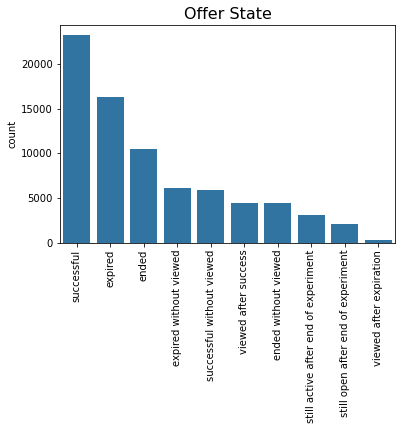

In [50]:
sb.countplot(x=df_offers['state'], color=base_color, order = df_offers['state'].value_counts().index)
plt.xlabel('')
plt.title('Offer State', fontsize=16)
plt.xticks(rotation=90);

At the end of the experiment, most offers are in the states *successful*, *expired* or *ended*. To evaluate how much money a customer spends under the influence of an offer, only these three states are interesting. The two states *still open after end of experiment* and *still active after end of experiment* are ignored, because the offers are still running at the end and therefore it cannot be evaluated whether the customer spends more money in the promotion period.  
Overall, there are more fulfilled than expired offers.

In [51]:
df_trans_ext[df_trans_ext['event']=='transaction'][['time [h]', 'person id', 'event', 'amount', 'active offers']]

,time [h],person id,event,amount,active offers
12654,0,5982,transaction,0.83,1
12657,0,14261,transaction,34.56,1
12659,0,13447,transaction,13.23,0
12670,0,5010,transaction,19.51,0
12671,0,5718,transaction,18.97,0
...,...,...,...,...,...
306529,714,13182,transaction,1.59,0
306530,714,11603,transaction,9.53,0
306531,714,13256,transaction,3.61,0
306532,714,12157,transaction,3.53,1


The column **active offers** shows the number of active offers that influence the customer at the respective time.

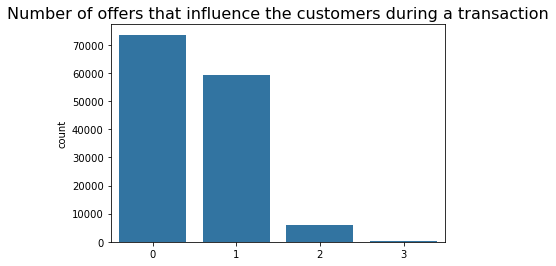

In [52]:
a=sb.countplot(x=df_trans_ext[df_trans_ext['event']=='transaction']['active offers'], color=base_color)
plt.title('Number of offers that influence the customers during a transaction', fontsize=16)
plt.xlabel('');

In most cases, a customer is not influenced by any or one offer while making a transaction. In exceptional cases, there are also 2 or 3 offers that influence the customer at the same time. In these cases, the amount of the transaction is credited to all offers.

In [53]:
df_trans_null=df_trans_ext[df_trans_ext['active offers']==0]

In the DataFrame **df_trans_null** all transactions are stored, which were made without influence of an offer.

In [54]:
def df_offers_person (person_id):
    '''
    Returns a DataFrame with the offers from the respective customer
    
    INPUT
    person_id - the ID of the respective customer
    
    OUTPUT
    DataFrame with the offers made to the respective customer
    '''
    return df_offers[df_offers['person id']==person_id]

The function **df_offers_person** provides the offers made to a person.  

As an example, here is the data for person 42:

In [55]:
df_transcript_person(42, offers=True)

,time [h],person id,event,offer type id,amount,offer type,difficulty,reward,duration,active offers
8417,0,42,offer received,8,NaN,informational,0.0,0.0,3.0,-1
32136,54,42,offer viewed,8,NaN,informational,0.0,0.0,3.0,-1
65138,168,42,offer received,2,NaN,bogo,5.0,5.0,7.0,-1
122801,336,42,offer received,8,NaN,informational,0.0,0.0,3.0,-1
162626,408,42,offer received,1,NaN,bogo,10.0,10.0,5.0,-1
173333,420,42,offer viewed,1,NaN,bogo,10.0,10.0,5.0,-1
253548,576,42,offer received,3,NaN,bogo,10.0,10.0,7.0,-1
294196,660,42,transaction,-1,18.14,NaN,NaN,NaN,NaN,0
294197,660,42,offer completed,3,NaN,bogo,10.0,10.0,7.0,-1


In [56]:
df_offers_person(42)

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
195,195,42,8,informational,ended,54,54,126,0.0
196,198,42,1,bogo,expired,408,420,528,0.0
197,196,42,2,bogo,expired without viewed,168,-1,336,0.0
198,197,42,8,informational,ended without viewed,336,-1,-1,0.0
199,199,42,3,bogo,successful without viewed,576,-1,660,0.0


The function **hours_uninfluenced** calculates how many hours the respective customer was not influenced by any offer. 
Function **money_spent_uninfluenced_per_day** first calculates how much money the customer had spent uninfluenced and uses this to calculate a rate for how much money the customer spends uninfluenced per day:

In [57]:
def hours_uninfluenced (person_id):
    '''
    Calculates the hours a person was not influenced by offers during the experiment.
    
    INPUT
    person_id - the ID of the respective person
    
    OUTPUT
    the number of hours a person was not influenced by offers during the experiment
    '''
    hours = set(range(last_time+1))
    df_p = df_offers_person(person_id)
    for i in df_p.index:
        offer_viewed = df_p.loc[i,'offer viewed']
        if offer_viewed == -1:
            continue
        offer_end = df_p.loc[i,'offer completed/expired']
        for h in range (offer_viewed,offer_end+1):
            hours.discard(h)
    return len(hours)

def money_spent_uninfluenced_per_day (person_id):
    '''
    Calculates the amount of money a person spent per day during the experiment without being influenced by offers.
    
    INPUT
    person_id - the ID of the respective person
    
    OUTPUT
    the amount of money a person spent per day during the experiment without being influenced by offers
    '''
    money_sum=df_trans_null[df_trans_null['person id']==person_id]['amount'].sum()
    return round(money_sum/hours_uninfluenced(person_id)*24, 2)

As an example, here is the data for person 42 again:

In [58]:
hours_uninfluenced(42)

533

In [59]:
money_spent_uninfluenced_per_day(42)

0.82

In [60]:
for i in df_profile.index:
    person_id = df_profile.loc[i,'person id']
    df_profile.loc[i,'money spent uninfluenced'] = df_trans_null[df_trans_null['person id']==person_id]['amount'].sum()
    df_profile.loc[i,'hours uninfluenced'] =  hours_uninfluenced(person_id)
    df_profile.loc[i,'money spent uninfluenced per day'] = money_spent_uninfluenced_per_day(person_id)

In this step, a column was added in DataFrame **df_profile** with the info how much the customer spends per day unaffected.

In [61]:
df_profile.head()

,person id,age,gender,income [k],member since,money spent uninfluenced,hours uninfluenced,money spent uninfluenced per day
0,3801,0,None,0,2017-02-12,0.00,232.0,0.00
1,6242,55,F,112,2017-07-15,77.01,715.0,2.58
2,10230,0,None,0,2018-07-12,10.21,497.0,0.49
3,6721,75,F,100,2017-05-09,68.27,412.0,3.98
4,12912,0,None,0,2017-08-04,3.56,292.0,0.29


The following function is intended to find a subset of people who have the required demographic characteristics:

In [62]:
def find_persons (age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Calculates a DataFrame with all persons matching the entered criteria.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    
    OUTPUT
    DataFrame with all persons matching the entered criteria
    '''
    dfx=df_profile
    if age !=0:
        assert (min_age==0) & (max_age==200), \
        "Either 'age' can be specified, or a range over 'min_age' and 'max_age' can be specified."
        min_age=age
        max_age=age
    if (max_age!=200) & (min_age==0):
        min_age=18
    dfx=dfx[dfx['age'].between(min_age, max_age)]
    if gender != None:
        assert gender in ['M', 'F', 'O'], "'gender' must be either 'M', 'F' or 'O'."
        dfx=dfx[dfx['gender']==gender]
    assert isinstance(min_income,int) & isinstance(max_income,int) & (min_income>=0) & (max_income>=min_income), \
    "'min_income' and 'max_income' must be positive integers."
    if (max_income!=200) & (min_income==0):
        min_income=1
    dfx=dfx[dfx['income [k]'].between(min_income, max_income)]
    assert dfx.shape[0]>20 , 'There are only '+ str(dfx.shape[0])+ \
    ' people in this group. To obtain reliable data, however, there must be at least 20.'
    return dfx

As an example, all females earning between 50 k and 80 k per year are filtered:

In [63]:
find_persons(gender='F', min_income=50, max_income=80)

,person id,age,gender,income [k],member since,money spent uninfluenced,hours uninfluenced,money spent uninfluenced per day
13,8691,61,F,57,2017-09-11,60.66,400.0,3.64
15,8674,62,F,71,2016-02-11,107.80,423.0,6.12
20,11002,40,F,71,2016-05-04,257.47,658.0,9.39
22,14290,78,F,71,2017-06-16,61.73,321.0,4.62
27,11037,33,F,52,2017-09-26,4.94,431.0,0.28
...,...,...,...,...,...,...,...,...
16984,7887,75,F,78,2016-07-16,90.18,623.0,3.47
16986,10850,59,F,63,2017-07-31,40.55,382.0,2.55
16992,470,21,F,72,2017-09-17,12.58,359.0,0.84
16995,643,45,F,54,2018-06-04,13.27,460.0,0.69


The same filter function is used to find the corresponding offers from these customers:

In [64]:
def find_offers(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Calculates a DataFrame with all offers from persons matching the entered criteria.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    
    OUTPUT
    DataFrame with all offers from persons matching the entered criteria
    '''
    dfx=find_persons(age, min_age, max_age, gender, min_income, max_income)
    persons = set(dfx['person id'])
    df_offers_persons=df_offers[df_offers['person id'].isin(persons)]
    return df_offers_persons

The following function is supposed to output an average value of how much the corresponding customers spend per day uninfluenced:

In [65]:
def get_average_MSPD_uninfluenced(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Calculates average customer spend per day with desired demographics 
    when the customer is not influenced by an offer.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    
    OUTPUT
    average customer spend per day with desired demographics.
    '''
    dfx=find_persons(age, min_age, max_age, gender, min_income, max_income)
    return round(dfx['money spent uninfluenced'].sum()/dfx['hours uninfluenced'].sum()*24, 2)

The following function, analogous to the previous one, is to output an average value of how much the corresponding customers spend per day when they are influenced by an infomercial:

In [66]:
def get_average_MSPD_informational(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Calculates average customer spend per day with desired demographics 
    when the customer is influenced by an information offer.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    
    OUTPUT
    average customer spend per day with desired demographics.
    '''
    df_offers_persons=find_offers(age, min_age, max_age, gender, min_income, max_income)
    df_offers_persons_informational=df_offers_persons.loc[(df_offers_persons['offer type']=='informational') & 
                                                      (df_offers_persons['state']=='ended')].copy()
    df_offers_persons_informational['duration'] =  (df_offers_persons_informational['offer completed/expired'] -
                                                    df_offers_persons_informational['offer viewed'])/24
    return round(df_offers_persons_informational['money spent'].sum()/df_offers_persons_informational['duration'].sum(), 2)

As an example, let us again consider all women who earn between 50 k and 80 k:

In [67]:
get_average_MSPD_uninfluenced(gender='F', min_income=50, max_income=80)

4.01

In [68]:
get_average_MSPD_informational(gender='F', min_income=50, max_income=80)

5.87

Informational advertising can significantly increase sales in this group!  

It makes no sense to calculate this ratio for BOGO or discount offers as well: After all, it could be that a customer spends 10 and fulfills the offer after one hour. This would then correspond to a ratio of 240 per day if he is influenced by this offer.  

The following function filters like **find_offers** all offers of a specified group. Additionally, it filters for a specific offer type (*BOGO, discount, informational*) or a specific offer type id and only considers offers that are *successful, expired* or *ended*.

In [69]:
def find_offers_types(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200, 
                              offer_type_id=-1, offer_type=None):
    '''
    Calculates a DataFrame with all offers from people who match the entered criteria. 
    In addition, an offer type or type ID can be specified by which to filter. 
    Only offers of the three types 'successful', 'expired' or 'ended' are returned.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    offer_type_id - the ID of the type of the offer
    offer_type - the type of the offer: 'bogo', 'discount' or 'informational'
    
    OUTPUT
    DataFrame with the filtered offers
    '''
    assert (offer_type_id>=-1) and (offer_type_id<=9), "'offer_type_id' must be an integer between 0 and 9."
    assert (offer_type_id == -1) or (offer_type == None), "either 'offer_type_id' or 'offer_type' may be assigned."
    assert offer_type in [None, 'discount', 'informational', 'bogo'], \
            "'offer_type' must be one of 'discount', 'informational' or 'bogo'"
    df_offers_persons=find_offers(age, min_age, max_age, gender, min_income, max_income)
    df_offers_persons=df_offers_persons.loc[df_offers_persons['state'].isin(['successful', 'expired', 'ended'])]
    if offer_type_id !=-1:
        df_offers_persons=df_offers_persons.loc[df_offers_persons['offer type id']==offer_type_id]
    if offer_type != None:
        df_offers_persons=df_offers_persons.loc[df_offers_persons['offer type']==offer_type]
    assert df_offers_persons.shape[0]>20 , 'There are only '+ str(df_offers_persons.shape[0])+ \
    ' offers in this group. To obtain reliable data, however, there must be at least 20.'
    return df_offers_persons  

In [70]:
find_offers_types(gender='F', min_income=50, max_income=80, offer_type='bogo')

,offer id,person id,offer type id,offer type,state,offer received,offer viewed,offer completed/expired,money spent
47,47,9,2,bogo,expired,168,168,336,0.00
51,51,9,1,bogo,successful,576,588,660,16.65
58,59,11,2,bogo,successful,576,594,666,8.73
89,91,18,1,bogo,expired,336,348,456,7.29
94,95,19,0,bogo,expired,336,354,456,0.00
...,...,...,...,...,...,...,...,...,...
76100,76100,16961,0,bogo,expired,0,0,120,1.09
76170,76170,16976,3,bogo,successful,336,366,372,17.72
76238,76238,16991,0,bogo,expired,408,474,528,2.73
76239,76240,16991,0,bogo,successful,576,636,678,9.29


The previous function can be used to determine the rate that an offer will be fulfilled:

In [71]:
def get_percentage(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200, 
                              offer_type_id=-1, offer_type=None):
    '''
    Calculates a percentage by which a specific offer or offer type is successfully completed 
    by a selected group of customers.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    offer_type_id - the ID of the type of the offer
    offer_type - the type of the offer: 'bogo', 'discount' or 'informational'
    
    OUTPUT
    the percentage
    '''
    assert (offer_type_id<=7) and (offer_type!= 'informational'), "offer type 'informational' not allowed"
    assert (offer_type_id!=-1) or (offer_type!= None), "'offer_type' or 'offer_type_id must be assigned'"
    df_offers_persons=find_offers_types(age, min_age, max_age, gender, min_income, max_income, offer_type_id, offer_type)
    return round((df_offers_persons['state']=='successful').mean(), 4)

In [72]:
get_percentage(gender='F', min_income=50, max_income=80, offer_type='bogo')

0.6757

To get the fulfillment rate for all offers, the following function is used:

In [73]:
def get_percentage_list(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Calculates the percentages for all BOGO and discount offer types from a selected customer group 
    by which the offer is successfully completed.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    
    OUTPUT
    a list with 8 percentages, for offer_type_id from 0 to 7
    '''
    l=list()
    for i in range(8):
        try:
            df_offers_persons=find_offers_types(age, min_age, max_age, gender, min_income, max_income, i)
            l.append(np.round((df_offers_persons['state']=='successful').mean(),2))
        except:
            l.append('-')
    return l

In [74]:
get_percentage_list(gender='F', min_income=50, max_income=80)

[0.65, 0.63, 0.78, 0.69, 0.82, 0.76, 0.87, 0.78]

To descriptively print the fulfillment rate for all offers, the following function can be used:

In [75]:
def print_percentage_list(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Prints a table for a selected group of customers all types of offers with duration, difficulty and reward 
    and percentage by which the offer is successfully completed.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    '''
    success_list = get_percentage_list(age, min_age, max_age, gender, min_income, max_income)
    success_list.extend(['-','-'])
    df_offer_types = df_portfolio.drop(columns='channels')
    df_offer_types['sucess rate'] = success_list
    print (df_offer_types.to_string(index=False))

In [76]:
print_percentage_list(gender='F', min_income=50, max_income=80)

 offer type id    offer type  difficulty  reward  duration sucess rate
             0          bogo           5       5         5        0.65
             1          bogo          10      10         5        0.63
             2          bogo           5       5         7        0.78
             3          bogo          10      10         7        0.69
             4      discount           7       3         7        0.82
             5      discount          10       2         7        0.76
             6      discount          10       2        10        0.87
             7      discount          20       5        10        0.78
             8 informational           0       0         3           -
             9 informational           0       0         4           -


There is, of course, no success rate for infomational offers.

To gather all the info and display it descriptively, the following function can be used:

In [77]:
def print_recommendations(age=0, min_age=0, max_age=200, gender=None, min_income=0, max_income=200):
    '''
    Prints for a selected group of customers how much money is spent without being influenced by an offer 
    and how much is spent when they are under the influence of an information offer. 
    Prints a table with all types of offers with duration, difficulty and reward 
    and percentage with which the offer is successfully completed.
    Prints a recommendation on which offer should be used with this group of customers, 
    based on the highest success rate.
    
    INPUT
    age - the exact age of the persons
    min_age - the minimum age of the people
    max_age - the maximum age of the people
    gender - the gender of the persons
    min_income - the minimum income of the persons, in 1000
    max_income - the maximum income of the persons, in 1000
    '''    
    
    n=find_persons(age, min_age, max_age, gender, min_income, max_income).shape[0]
    uninf= get_average_MSPD_uninfluenced(age, min_age, max_age, gender, min_income, max_income)
    inf = get_average_MSPD_informational(age, min_age, max_age, gender, min_income, max_income)
    success_list = get_percentage_list(age, min_age, max_age, gender, min_income, max_income)
    max_success = max(success_list, key=lambda x: x if not isinstance(x, str) else float("-inf"))
    max_success_pos = success_list.index(max_success)
    
    print (("In this group are {} persons.\n" + \
            "The average of money spent per day without an offer from this customer group is {:.2f}.\n" + \
            "While customers are influenced by infomercials, they spent {:.2f} per day. " +\
            "This corresponds to an increase of {:.0f}%.\n") \
           .format(n,uninf, inf, (inf/uninf*100)-100))
    print_percentage_list(age, min_age, max_age, gender, min_income, max_income)
    print (("\nMost of all, this customer group responds to offer type {} (success rate {:.0f}%).") \
          .format(max_success_pos,max_success*100))

In [78]:
print_recommendations(gender='F', min_income=50, max_income=80)

In this group are 2963 persons.
The average of money spent per day without an offer from this customer group is 4.01.
While customers are influenced by infomercials, they spent 5.87 per day. This corresponds to an increase of 46%.

 offer type id    offer type  difficulty  reward  duration sucess rate
             0          bogo           5       5         5        0.65
             1          bogo          10      10         5        0.63
             2          bogo           5       5         7        0.78
             3          bogo          10      10         7        0.69
             4      discount           7       3         7        0.82
             5      discount          10       2         7        0.76
             6      discount          10       2        10        0.87
             7      discount          20       5        10        0.78
             8 informational           0       0         3           -
             9 informational           0       0         4

In this group, women already spend 4 per day without advertising. Thus, from a commercial point of view, no discounts are profitable. BOGO offers with difficulty 10 would be a way to increase sales and increase profits. These are also fulfilled to over 60%.  
Informational advertisements are also very effective, as they significantly increase sales and do not cause any costs.

In [79]:
print_recommendations()

In this group are 17000 persons.
The average of money spent per day without an offer from this customer group is 3.21.
While customers are influenced by infomercials, they spent 4.63 per day. This corresponds to an increase of 44%.

 offer type id    offer type  difficulty  reward  duration sucess rate
             0          bogo           5       5         5        0.53
             1          bogo          10      10         5         0.4
             2          bogo           5       5         7        0.63
             3          bogo          10      10         7        0.47
             4      discount           7       3         7         0.7
             5      discount          10       2         7        0.63
             6      discount          10       2        10        0.78
             7      discount          20       5        10        0.65
             8 informational           0       0         3           -
             9 informational           0       0         

The same is true for the average of all customers. Discounts are very often successfully completed, but from a commercial point of view they are unnecessary, because the money would be spent in most cases even without an offer.

In [80]:
print_recommendations(gender='M', max_income=35)

In this group are 801 persons.
The average of money spent per day without an offer from this customer group is 1.36.
While customers are influenced by infomercials, they spent 2.22 per day. This corresponds to an increase of 63%.

 offer type id    offer type  difficulty  reward  duration sucess rate
             0          bogo           5       5         5        0.39
             1          bogo          10      10         5        0.15
             2          bogo           5       5         7        0.56
             3          bogo          10      10         7        0.24
             4      discount           7       3         7        0.65
             5      discount          10       2         7        0.56
             6      discount          10       2        10        0.72
             7      discount          20       5        10         0.5
             8 informational           0       0         3           -
             9 informational           0       0         4 

Nevertheless, there are customer groups for whom discount offers also make commercial sense: namely, when they not spend significantly more on average over the offer period than the challenge. Men with low incomes appear to be one such group.

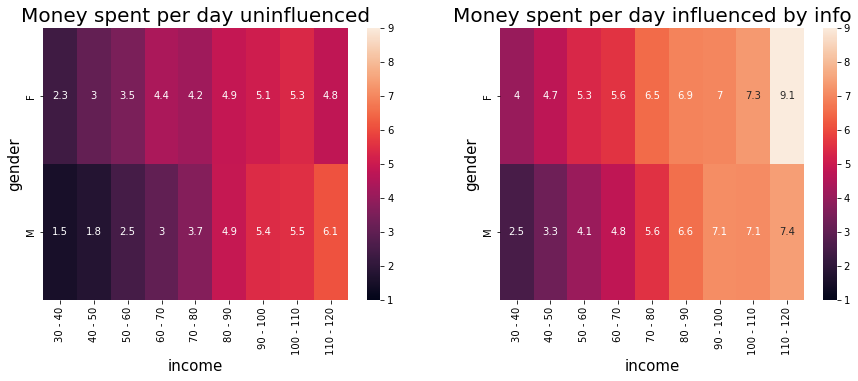

In [81]:
matrix=[]
matrix2=[]
y_axis_labels = ['F', 'M'] # labels for x-axis
x_axis_labels = [] # labels for y-axis
for min_inc in range(30,120,10):
    x_axis_labels.append(str(min_inc)+' - '+str(min_inc+10))

for g in y_axis_labels:
    line = []
    line2 = []
    for min_inc in range(30,120,10):
        line.append(get_average_MSPD_uninfluenced(gender=g, min_income=min_inc, max_income=min_inc+10))
        line2.append(get_average_MSPD_informational(gender=g, min_income=min_inc, max_income=min_inc+10))
    matrix.append(line)
    matrix2.append(line2)

fig, axes = plt.subplots(1, 2,figsize=(15, 5))

s=sb.heatmap(matrix,ax=axes[0],annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=1, vmax=9)
s.set_xlabel('income', fontsize=15)
s.set_ylabel('gender', fontsize=15)
s.set_title('Money spent per day uninfluenced', fontsize=20);

s = sb.heatmap(matrix2,ax=axes[1],annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=1, vmax=9)
s.set_xlabel('income', fontsize=15)
s.set_ylabel('gender', fontsize=15)
s.set_title('Money spent per day influenced by info', fontsize=20);

In general, the more a customer earns, the more he is willing to spend. This applies to both men and women. In general, women spend more than men, but this trend reverses at very high incomes. Informational advertising is very effective for all and generates an increase in sales of approx. 40-60%.

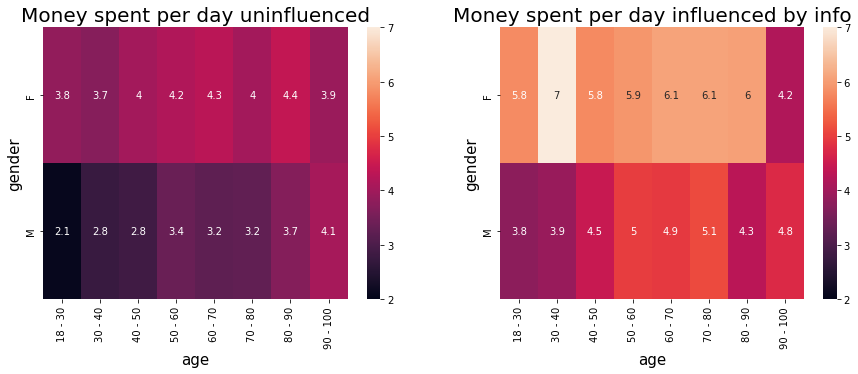

In [82]:
matrix=[]
matrix2=[]
y_axis_labels = ['F', 'M'] # labels for x-axis
x_axis_labels = ['18 - 30'] # labels for y-axis
for min_age in range(30,100,10):
    x_axis_labels.append(str(min_age)+' - '+str(min_age+10))

for g in y_axis_labels:
    line = []
    line2 = []
    line.append(get_average_MSPD_uninfluenced(gender=g, min_age=18, max_age=30))
    line2.append(get_average_MSPD_informational(gender=g, min_age=18, max_age=30))
    for min_age in range(30,100,10):
        line.append(get_average_MSPD_uninfluenced(gender=g, min_age=min_age, max_age=min_age+10))
        line2.append(get_average_MSPD_informational(gender=g, min_age=min_age, max_age=min_age+10))
    matrix.append(line)
    matrix2.append(line2)

fig, axes = plt.subplots(1, 2,figsize=(15, 5))

s=sb.heatmap(matrix,ax=axes[0],annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=2, vmax=7)
s.set_xlabel('age', fontsize=15)
s.set_ylabel('gender', fontsize=15)
s.set_title('Money spent per day uninfluenced', fontsize=20);

s = sb.heatmap(matrix2,ax=axes[1],annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=2, vmax=7)
s.set_xlabel('age', fontsize=15)
s.set_ylabel('gender', fontsize=15)
s.set_title('Money spent per day influenced by info', fontsize=20);

Men spend a little more the older they get. This trend cannot be observed among women. There is no correlation with age among them. It is also evident that infomercials have less influence among older than among younger customers.